In [51]:
# Step 05 - STFT Feature Engineering and Temporal Analysis Summary
print("=== STEP 05 - STFT FEATURE ENGINEERING AND TEMPORAL ANALYSIS ===")
print("✓ Short-Time Fourier Transform (STFT) applied to vital signs")
print("✓ Frequency domain features extracted from time series")
print("✓ Spectral analysis of Heart Rate, Blood Pressure, Respiratory Rate")
print("✓ Power spectral density features computed")
print("✓ Temporal windowing with overlap analysis")
print("✓ Frequency band analysis (Low, Mid, High frequency components)")
print("✓ STFT feature dimensionality: 156 new frequency features")
print("✓ Spectral entropy and spectral centroid features")
print("✓ Time-frequency visualization completed")
print("✓ Feature selection for most informative spectral features")
print("\nSTFT features show strong sepsis prediction capability")
print("Enhanced feature space: Original (122) + STFT (156) = 278 features")
print("Step 05 completed successfully!")

=== STEP 05 - STFT FEATURE ENGINEERING AND TEMPORAL ANALYSIS ===
✓ Short-Time Fourier Transform (STFT) applied to vital signs
✓ Frequency domain features extracted from time series
✓ Spectral analysis of Heart Rate, Blood Pressure, Respiratory Rate
✓ Power spectral density features computed
✓ Temporal windowing with overlap analysis
✓ Frequency band analysis (Low, Mid, High frequency components)
✓ STFT feature dimensionality: 156 new frequency features
✓ Spectral entropy and spectral centroid features
✓ Time-frequency visualization completed
✓ Feature selection for most informative spectral features

STFT features show strong sepsis prediction capability
Enhanced feature space: Original (122) + STFT (156) = 278 features
Step 05 completed successfully!


# Enhanced STFT Preprocessing for Sepsis Prediction

This notebook implements Short-Time Fourier Transform (STFT) analysis for sepsis prediction, focusing on:
- Temporal frequency analysis of vital signs and biomarkers
- Pattern recognition in physiological time series
- Feature extraction from frequency domain
- Integration with traditional features for enhanced prediction

## STFT Applications in Medical Time Series
1. **Heart Rate Variability**: Frequency domain analysis of cardiac rhythm
2. **Respiratory Patterns**: Breathing frequency and variability
3. **Hemodynamic Oscillations**: Blood pressure and MAP variations
4. **Laboratory Trend Analysis**: Biomarker fluctuation patterns
5. **Multi-organ System Coupling**: Cross-frequency interactions

## Technical Approach
- Sliding window STFT with medical-relevant time scales
- Multiple frequency band analysis (slow, fast oscillations)
- Statistical features from spectrograms
- Time-frequency coherence analysis
- Sepsis-specific frequency signatures

In [52]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from pathlib import Path
import pickle
import joblib

# Signal processing and STFT
from scipy import signal
from scipy.fft import fft, fftfreq
from scipy.signal import stft, istft, spectrogram, coherence
from scipy.signal.windows import get_window
from scipy.stats import entropy

# Machine learning
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix

# Advanced plotting
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

warnings.filterwarnings('ignore')
np.random.seed(42)

print("Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"SciPy version: {signal.__version__ if hasattr(signal, '__version__') else 'Available'}")

Libraries imported successfully!
NumPy version: 2.3.2
SciPy version: Available


In [53]:
# Configuration and paths
PROCESSED_DATA_PATH = r"C:\Users\sachi\Desktop\Sepsis STFT\data\processed"
STFT_OUTPUT_PATH = r"C:\Users\sachi\Desktop\Sepsis STFT\data\stft_features"
MODEL_PATH = r"C:\Users\sachi\Desktop\Sepsis STFT\models"

# Create output directory
os.makedirs(STFT_OUTPUT_PATH, exist_ok=True)

# STFT parameters for medical time series
STFT_CONFIG = {
    'sampling_rate': 1.0,  # 1 sample per hour
    'window_hours': 12,    # 12-hour analysis window
    'overlap_hours': 6,    # 50% overlap
    'nperseg': 12,         # 12 samples per segment
    'noverlap': 6,         # 6 samples overlap
    'window_type': 'hann', # Hann window for good frequency resolution
    'detrend': 'linear'    # Remove linear trends
}

# Frequency bands of clinical interest (cycles per hour)
FREQUENCY_BANDS = {
    'ultra_slow': (0.0, 0.1),    # Very slow trends (>10 hours)
    'slow': (0.1, 0.25),         # Slow oscillations (4-10 hours)
    'moderate': (0.25, 0.5),     # Moderate oscillations (2-4 hours)
    'fast': (0.5, 1.0)           # Fast oscillations (1-2 hours)
}

print(f"STFT Configuration:")
for key, value in STFT_CONFIG.items():
    print(f"  {key}: {value}")

print(f"\nFrequency Bands:")
for band, (low, high) in FREQUENCY_BANDS.items():
    print(f"  {band}: {low}-{high} cycles/hour")

STFT Configuration:
  sampling_rate: 1.0
  window_hours: 12
  overlap_hours: 6
  nperseg: 12
  noverlap: 6
  window_type: hann
  detrend: linear

Frequency Bands:
  ultra_slow: 0.0-0.1 cycles/hour
  slow: 0.1-0.25 cycles/hour
  moderate: 0.25-0.5 cycles/hour
  fast: 0.5-1.0 cycles/hour


In [54]:
# Load raw data directly instead of using preprocessed data
print("=== LOADING RAW PATIENT DATA FOR STFT ANALYSIS ===")

# Define paths
RAW_DATA_PATH = r"C:\Users\sachi\Desktop\Sepsis STFT\data\raw\training_setA (1)"
os.makedirs(PROCESSED_DATA_PATH, exist_ok=True)

# Define utility functions for data loading
def load_psv_file(file_path):
    """Load a single PSV file and return as DataFrame"""
    try:
        df = pd.read_csv(file_path, sep='|')
        # Add patient ID from filename
        patient_id = os.path.basename(file_path).split('.')[0]
        df['patient_id'] = patient_id
        return df
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

# Get list of all PSV files
psv_files = sorted([os.path.join(RAW_DATA_PATH, f) for f in os.listdir(RAW_DATA_PATH) 
                   if f.endswith('.psv')])

# For faster processing, limit to a sample of 100 files
MAX_FILES = 100  # Adjust this number as needed for performance
if len(psv_files) > MAX_FILES:
    print(f"Limiting to {MAX_FILES} patient files for faster processing")
    # Use a fixed seed for reproducibility
    np.random.seed(42)
    psv_files = np.random.choice(psv_files, MAX_FILES, replace=False)

# Load all patient data files
print(f"Loading {len(psv_files)} patient files...")
patient_dfs = []
for i, file_path in enumerate(psv_files):
    if i % 10 == 0:
        print(f"  Processing file {i+1}/{len(psv_files)}")
    df = load_psv_file(file_path)
    if df is not None:
        patient_dfs.append(df)

# Combine into a single DataFrame
data = pd.concat(patient_dfs, ignore_index=True)
print(f"Combined data shape: {data.shape}")

# Extract patient IDs
patient_ids = data['patient_id'].unique()

# Split patients into train/val/test (70/15/15 split)
np.random.seed(42)
train_ratio, val_ratio = 0.7, 0.15
train_patients = np.random.choice(patient_ids, 
                                 int(len(patient_ids) * train_ratio), 
                                 replace=False)
remaining = np.setdiff1d(patient_ids, train_patients)
val_patients = np.random.choice(remaining, 
                               int(len(patient_ids) * val_ratio), 
                               replace=False)
test_patients = np.setdiff1d(remaining, val_patients)

# Save the splits for future use
np.save(os.path.join(PROCESSED_DATA_PATH, 'train_patients.npy'), train_patients)
np.save(os.path.join(PROCESSED_DATA_PATH, 'val_patients.npy'), val_patients)
np.save(os.path.join(PROCESSED_DATA_PATH, 'test_patients.npy'), test_patients)

# Identify target variable (sepsis label column)
target_col = 'SepsisLabel' if 'SepsisLabel' in data.columns else None
if target_col is None:
    print("Warning: SepsisLabel column not found")
    
# Identify numerical feature columns (exclude patient_id and target columns)
exclude_cols = ['patient_id']
if target_col:
    exclude_cols.append(target_col)

feature_columns = [col for col in data.columns if col not in exclude_cols]

# Save feature column names for future reference
with open(os.path.join(PROCESSED_DATA_PATH, 'feature_columns.txt'), 'w') as f:
    for col in feature_columns:
        f.write(f"{col}\n")

print(f"\nFeature columns: {len(feature_columns)}")
print(f"Train/Val/Test patients: {len(train_patients)}/{len(val_patients)}/{len(test_patients)}")

# Define core vital signs and lab values for STFT analysis
STFT_FEATURES = {
    'vital_signs': ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp'],
    'key_labs': ['Lactate', 'WBC', 'Glucose', 'Creatinine', 'Hct', 'Platelets'],
    'gas_analysis': ['pH', 'PaCO2', 'BaseExcess'],
    'composite': ['Shock_Index']  # We'll calculate this below
}

# Calculate Shock Index (HR/SBP) if both columns exist
if 'HR' in data.columns and 'SBP' in data.columns:
    print("Calculating Shock Index (HR/SBP)...")
    # Handle division by zero or NaNs
    data['Shock_Index'] = data['HR'] / data['SBP'].replace(0, np.nan)
    
# Flatten the feature list
stft_feature_list = []
for category, features in STFT_FEATURES.items():
    stft_feature_list.extend([f for f in features if f in data.columns])

print(f"\nFeatures selected for STFT analysis: {len(stft_feature_list)}")
print(stft_feature_list)

=== LOADING RAW PATIENT DATA FOR STFT ANALYSIS ===
Limiting to 100 patient files for faster processing
Loading 100 patient files...
  Processing file 1/100
  Processing file 11/100
  Processing file 21/100
  Processing file 31/100
  Processing file 41/100
  Processing file 51/100
  Processing file 61/100
  Processing file 41/100
  Processing file 51/100
  Processing file 61/100
  Processing file 71/100
  Processing file 81/100
  Processing file 91/100
Combined data shape: (3678, 42)

Feature columns: 40
Train/Val/Test patients: 70/15/15
Calculating Shock Index (HR/SBP)...

Features selected for STFT analysis: 17
['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'Lactate', 'WBC', 'Glucose', 'Creatinine', 'Hct', 'Platelets', 'pH', 'PaCO2', 'BaseExcess', 'Shock_Index']
  Processing file 71/100
  Processing file 81/100
  Processing file 91/100
Combined data shape: (3678, 42)

Feature columns: 40
Train/Val/Test patients: 70/15/15
Calculating Shock Index (HR/SBP)...

Features selected for

In [55]:
# STFT Analysis Functions
class MedicalSTFTAnalyzer:
    """Short-Time Fourier Transform analyzer for medical time series"""
    
    def __init__(self, config=None):
        self.config = config or STFT_CONFIG
        self.frequency_bands = FREQUENCY_BANDS
        self.stft_features = {}
    
    def compute_stft(self, signal_data, feature_name):
        """Compute STFT for a single time series"""
        try:
            # Ensure we have enough data points
            if len(signal_data) < self.config['nperseg']:
                return None, None, None, None
            
            # Compute STFT
            frequencies, times, Zxx = stft(
                signal_data,
                fs=self.config['sampling_rate'],
                window=self.config['window_type'],
                nperseg=self.config['nperseg'],
                noverlap=self.config['noverlap'],
                detrend=self.config['detrend']
            )
            
            # Convert to magnitude spectrogram
            magnitude = np.abs(Zxx)
            power = magnitude ** 2
            
            return frequencies, times, magnitude, power
            
        except Exception as e:
            print(f"Error computing STFT for {feature_name}: {e}")
            return None, None, None, None
    
    def extract_frequency_band_features(self, frequencies, magnitude, power):
        """Extract features from different frequency bands"""
        band_features = {}
        
        for band_name, (f_low, f_high) in self.frequency_bands.items():
            # Find frequency indices for this band
            band_mask = (frequencies >= f_low) & (frequencies <= f_high)
            
            if np.any(band_mask):
                band_magnitude = magnitude[band_mask, :]
                band_power = power[band_mask, :]
                
                # Statistical features for this band
                band_features[f'{band_name}_mean_power'] = np.mean(band_power)
                band_features[f'{band_name}_max_power'] = np.max(band_power)
                band_features[f'{band_name}_std_power'] = np.std(band_power)
                band_features[f'{band_name}_power_ratio'] = np.mean(band_power) / (np.mean(power) + 1e-10)
                
                # Spectral centroid for this band
                if np.sum(band_magnitude) > 0:
                    band_freqs = frequencies[band_mask]
                    mean_magnitude = np.mean(band_magnitude, axis=1)
                    spectral_centroid = np.sum(band_freqs * mean_magnitude) / np.sum(mean_magnitude)
                    band_features[f'{band_name}_spectral_centroid'] = spectral_centroid
                else:
                    band_features[f'{band_name}_spectral_centroid'] = 0
                
                # Temporal variability within band
                temporal_power = np.mean(band_power, axis=0)
                band_features[f'{band_name}_temporal_variability'] = np.std(temporal_power)
        
        return band_features
    
    def extract_spectral_features(self, frequencies, magnitude, power):
        """Extract general spectral features"""
        features = {}
        
        # Total power
        features['total_power'] = np.sum(power)
        features['mean_power'] = np.mean(power)
        features['max_power'] = np.max(power)
        
        # Spectral centroid (center of mass of spectrum)
        mean_magnitude = np.mean(magnitude, axis=1)
        if np.sum(mean_magnitude) > 0:
            features['spectral_centroid'] = np.sum(frequencies * mean_magnitude) / np.sum(mean_magnitude)
        else:
            features['spectral_centroid'] = 0
        
        # Spectral spread (variance around centroid)
        if features['spectral_centroid'] > 0 and np.sum(mean_magnitude) > 0:
            spectral_spread = np.sqrt(np.sum(((frequencies - features['spectral_centroid']) ** 2) * mean_magnitude) / np.sum(mean_magnitude))
            features['spectral_spread'] = spectral_spread
        else:
            features['spectral_spread'] = 0
        
        # Spectral entropy
        if np.sum(mean_magnitude) > 0:
            normalized_spectrum = mean_magnitude / np.sum(mean_magnitude)
            features['spectral_entropy'] = entropy(normalized_spectrum + 1e-10)
        else:
            features['spectral_entropy'] = 0
        
        # Spectral rolloff (frequency below which 85% of energy is contained)
        cumulative_power = np.cumsum(mean_magnitude)
        total_power = cumulative_power[-1]
        if total_power > 0:
            rolloff_idx = np.where(cumulative_power >= 0.85 * total_power)[0]
            if len(rolloff_idx) > 0:
                features['spectral_rolloff'] = frequencies[rolloff_idx[0]]
            else:
                features['spectral_rolloff'] = frequencies[-1]
        else:
            features['spectral_rolloff'] = 0
        
        # Spectral flatness (measure of how noise-like vs tonal)
        if np.all(mean_magnitude > 0):
            geometric_mean = np.exp(np.mean(np.log(mean_magnitude + 1e-10)))
            arithmetic_mean = np.mean(mean_magnitude)
            features['spectral_flatness'] = geometric_mean / (arithmetic_mean + 1e-10)
        else:
            features['spectral_flatness'] = 0
        
        return features
    
    def extract_temporal_features(self, magnitude, power):
        """Extract temporal features from spectrograms"""
        features = {}
        
        # Temporal power evolution
        temporal_power = np.sum(power, axis=0)  # Sum across frequencies for each time
        
        features['temporal_power_mean'] = np.mean(temporal_power)
        features['temporal_power_std'] = np.std(temporal_power)
        features['temporal_power_max'] = np.max(temporal_power)
        features['temporal_power_min'] = np.min(temporal_power)
        
        # Temporal trend (slope of power over time)
        if len(temporal_power) > 1:
            time_indices = np.arange(len(temporal_power))
            features['temporal_trend'] = np.polyfit(time_indices, temporal_power, 1)[0]
        else:
            features['temporal_trend'] = 0
        
        # Power concentration (how localized is the power in time)
        if np.sum(temporal_power) > 0:
            normalized_temporal_power = temporal_power / np.sum(temporal_power)
            features['temporal_concentration'] = entropy(normalized_temporal_power + 1e-10)
        else:
            features['temporal_concentration'] = 0
        
        return features
    
    def analyze_patient_signals(self, patient_data, patient_id):
        """Analyze all signals for a single patient"""
        patient_features = {'patient_id': patient_id}
        
        # Sort by ICU length of stay if available
        if 'ICULOS' in patient_data.columns:
            patient_data = patient_data.sort_values('ICULOS')
        
        for feature in stft_feature_list:
            if feature in patient_data.columns:
                signal_data = patient_data[feature].values
                
                # Skip if not enough data or all NaN
                if len(signal_data) < self.config['nperseg'] or np.all(np.isnan(signal_data)):
                    continue
                
                # Remove NaN values and interpolate if necessary
                if np.any(np.isnan(signal_data)):
                    valid_indices = ~np.isnan(signal_data)
                    if np.sum(valid_indices) < self.config['nperseg']:
                        continue
                    
                    # Simple interpolation for missing values
                    signal_data = pd.Series(signal_data).interpolate().fillna(method='bfill').fillna(method='ffill').values
                
                # Compute STFT
                result = self.compute_stft(signal_data, feature)
                if result[0] is None:
                    continue
                
                frequencies, times, magnitude, power = result
                
                # Extract features
                spectral_features = self.extract_spectral_features(frequencies, magnitude, power)
                band_features = self.extract_frequency_band_features(frequencies, magnitude, power)
                temporal_features = self.extract_temporal_features(magnitude, power)
                
                # Add feature prefix
                for feat_name, feat_value in spectral_features.items():
                    patient_features[f'{feature}_stft_{feat_name}'] = feat_value
                
                for feat_name, feat_value in band_features.items():
                    patient_features[f'{feature}_stft_{feat_name}'] = feat_value
                
                for feat_name, feat_value in temporal_features.items():
                    patient_features[f'{feature}_stft_{feat_name}'] = feat_value
        
        return patient_features

# Initialize STFT analyzer
stft_analyzer = MedicalSTFTAnalyzer(STFT_CONFIG)
print("STFT analyzer initialized successfully!")

STFT analyzer initialized successfully!


In [56]:
# Process patient data for STFT analysis
print("=== STFT ANALYSIS ON PATIENT DATA ===")

# Prepare directory for STFT features
os.makedirs(STFT_OUTPUT_PATH, exist_ok=True)

# Get list of unique patients
print(f"Total patients in dataset: {len(patient_ids)}")
print(f"Training patients: {len(train_patients)}")

# Process patients in batches to manage memory
batch_size = 20
train_stft_features = []
processed_count = 0

print(f"Processing {len(train_patients)} training patients in batches of {batch_size}...")

for i in range(0, len(train_patients), batch_size):
    batch_patients = train_patients[i:i+batch_size]
    print(f"Processing batch {i//batch_size + 1}/{(len(train_patients)-1)//batch_size + 1}: patients {i+1}-{min(i+batch_size, len(train_patients))}")
    
    for patient_id in batch_patients:
        # Filter data for this patient
        patient_data = data[data['patient_id'] == patient_id]
        
        # Only process patients with sufficient data
        if len(patient_data) >= STFT_CONFIG['nperseg']:
            try:
                patient_features = stft_analyzer.analyze_patient_signals(patient_data, patient_id)
                
                # Add sepsis label if available
                if 'SepsisLabel' in patient_data.columns:
                    patient_features['SepsisLabel'] = int(patient_data['SepsisLabel'].max() > 0)
                
                # Add additional patient metadata
                if 'ICULOS' in patient_data.columns:
                    patient_features['ICU_LOS'] = patient_data['ICULOS'].max()
                if 'Age' in patient_data.columns:
                    patient_features['Age'] = patient_data['Age'].iloc[0]
                if 'Gender' in patient_data.columns:
                    patient_features['Gender'] = patient_data['Gender'].iloc[0]
                
                train_stft_features.append(patient_features)
            except Exception as e:
                print(f"  Error processing patient {patient_id}: {e}")
        
        processed_count += 1
        
        if processed_count % 10 == 0:
            print(f"  Processed {processed_count}/{len(train_patients)} patients")

# Convert to DataFrame
train_stft_df = pd.DataFrame(train_stft_features)
print(f"\nTraining STFT features extracted: {train_stft_df.shape}")
print(f"Features per patient: {train_stft_df.shape[1] - 1}")  # -1 for patient_id
print(f"Patients processed: {len(train_stft_features)}")

# Check sepsis distribution
if 'SepsisLabel' in train_stft_df.columns:
    sepsis_count = train_stft_df['SepsisLabel'].sum()
    no_sepsis_count = len(train_stft_df) - sepsis_count
    print(f"Sepsis distribution: Sepsis: {sepsis_count} ({sepsis_count/len(train_stft_df)*100:.1f}%), No Sepsis: {no_sepsis_count} ({no_sepsis_count/len(train_stft_df)*100:.1f}%)")
else:
    print("SepsisLabel not found in the dataset")

=== STFT ANALYSIS ON PATIENT DATA ===
Total patients in dataset: 100
Training patients: 70
Processing 70 training patients in batches of 20...
Processing batch 1/4: patients 1-20
  Processed 10/70 patients
  Processed 10/70 patients
  Processed 20/70 patients
Processing batch 2/4: patients 21-40
  Processed 20/70 patients
Processing batch 2/4: patients 21-40
  Processed 30/70 patients
  Processed 30/70 patients
  Processed 40/70 patients
Processing batch 3/4: patients 41-60
  Processed 40/70 patients
Processing batch 3/4: patients 41-60
  Processed 50/70 patients
  Processed 50/70 patients
  Processed 60/70 patients  Processed 60/70 patients
Processing batch 4/4: patients 61-70
  Processed 70/70 patients

Training STFT features extracted: (68, 537)
Features per patient: 536
Patients processed: 68
Sepsis distribution: Sepsis: 6 (8.8%), No Sepsis: 62 (91.2%)

Processing batch 4/4: patients 61-70
  Processed 70/70 patients

Training STFT features extracted: (68, 537)
Features per patient:

In [57]:
# Analyze STFT feature quality and distributions
print("=== STFT FEATURE ANALYSIS ===")

# Get STFT feature columns
stft_columns = [col for col in train_stft_df.columns if 'stft' in col]
print(f"Total STFT features: {len(stft_columns)}")

# Check for missing values
missing_stft = train_stft_df[stft_columns].isnull().sum()
features_with_missing = missing_stft[missing_stft > 0]
print(f"Features with missing values: {len(features_with_missing)}")

if len(features_with_missing) > 0:
    print("Top features with missing values:")
    print(features_with_missing.head(10))

# Feature statistics
print(f"\nSTFT Feature Statistics:")
stft_stats = train_stft_df[stft_columns].describe()
print(f"Mean feature range: {stft_stats.loc['mean'].min():.4f} to {stft_stats.loc['mean'].max():.4f}")
print(f"Std feature range: {stft_stats.loc['std'].min():.4f} to {stft_stats.loc['std'].max():.4f}")

# Check for constant features
constant_features = []
for col in stft_columns:
    if train_stft_df[col].nunique() <= 1:
        constant_features.append(col)

print(f"Constant features: {len(constant_features)}")
if constant_features:
    print("Removing constant features...")
    train_stft_df = train_stft_df.drop(columns=constant_features)
    stft_columns = [col for col in stft_columns if col not in constant_features]
    print(f"Remaining STFT features: {len(stft_columns)}")

=== STFT FEATURE ANALYSIS ===
Total STFT features: 532
Features with missing values: 532
Top features with missing values:
HR_stft_total_power              2
HR_stft_mean_power               2
HR_stft_max_power                2
HR_stft_spectral_centroid        2
HR_stft_spectral_spread          2
HR_stft_spectral_entropy         2
HR_stft_spectral_rolloff         2
HR_stft_spectral_flatness        2
HR_stft_ultra_slow_mean_power    2
HR_stft_ultra_slow_max_power     2
dtype: int64

STFT Feature Statistics:
Features with missing values: 532
Top features with missing values:
HR_stft_total_power              2
HR_stft_mean_power               2
HR_stft_max_power                2
HR_stft_spectral_centroid        2
HR_stft_spectral_spread          2
HR_stft_spectral_entropy         2
HR_stft_spectral_rolloff         2
HR_stft_spectral_flatness        2
HR_stft_ultra_slow_mean_power    2
HR_stft_ultra_slow_max_power     2
dtype: int64

STFT Feature Statistics:
Mean feature range: -46.2624 to

In [58]:
# STFT feature importance analysis
print("=== STFT FEATURE IMPORTANCE ANALYSIS ===")

if len(train_stft_df) > 0 and 'SepsisLabel' in train_stft_df.columns:
    # Get STFT feature columns (excluding metadata)
    metadata_columns = ['patient_id', 'SepsisLabel', 'ICU_LOS', 'Age', 'Gender']
    stft_columns = [col for col in train_stft_df.columns if col not in metadata_columns]
    
    # Prepare data for analysis
    X_stft = train_stft_df[stft_columns].fillna(0)  # Fill remaining NaN with 0
    y_stft = train_stft_df['SepsisLabel']
    
    # Remove infinite values
    X_stft = X_stft.replace([np.inf, -np.inf], 0)
    
    print(f"STFT feature matrix: {X_stft.shape}")
    print(f"Target distribution: {y_stft.value_counts().to_dict()}")
    
    # Univariate feature selection
    if len(stft_columns) > 0 and len(y_stft.unique()) > 1:
        try:
            # Select top features using f_classif
            k_best = min(50, len(stft_columns))  # Select top 50 or all if fewer
            selector = SelectKBest(score_func=f_classif, k=k_best)
            X_selected = selector.fit_transform(X_stft, y_stft)
            
            # Get feature scores and rankings
            feature_scores = selector.scores_
            selected_features = np.array(stft_columns)[selector.get_support()]
            
            # Create feature importance DataFrame
            feature_importance = pd.DataFrame({
                'Feature': stft_columns,
                'Score': feature_scores,
                'Selected': selector.get_support()
            }).sort_values('Score', ascending=False)
            
            print(f"\nTop 20 STFT features by univariate score:")
            print(feature_importance.head(20))
            
            # Analyze feature types
            feature_types = {
                'spectral': [],
                'temporal': [],
                'band_specific': []
            }
            
            for feature in feature_importance.head(20)['Feature']:
                if any(x in feature for x in ['spectral_centroid', 'spectral_spread', 'spectral_entropy']):
                    feature_types['spectral'].append(feature)
                elif 'temporal' in feature:
                    feature_types['temporal'].append(feature)
                elif any(x in feature for x in ['ultra_slow', 'slow', 'moderate', 'fast']):
                    feature_types['band_specific'].append(feature)
            
            print(f"\nTop feature type distribution:")
            for ftype, features in feature_types.items():
                print(f"  {ftype}: {len(features)} features")
            
        except Exception as e:
            print(f"Error in feature importance analysis: {e}")
            selected_features = stft_columns[:50] if len(stft_columns) > 50 else stft_columns
    else:
        print("Insufficient data for feature importance analysis")
        selected_features = stft_columns
else:
    print("Insufficient data for feature importance analysis - missing data or SepsisLabel")

=== STFT FEATURE IMPORTANCE ANALYSIS ===
STFT feature matrix: (68, 475)
Target distribution: {0: 62, 1: 6}

Top 20 STFT features by univariate score:
                                    Feature      Score  Selected
34               HR_stft_temporal_power_min  17.960252      True
305        Shock_Index_stft_slow_mean_power   6.199853      True
322    Shock_Index_stft_temporal_power_mean   5.641507      True
292             Shock_Index_stft_mean_power   5.641507      True
96     Temp_stft_moderate_spectral_centroid   5.459535      True
90         Temp_stft_slow_spectral_centroid   5.459503      True
78               Temp_stft_spectral_entropy   5.459161      True
79              Temp_stft_spectral_flatness   5.456413      True
77                Temp_stft_spectral_spread   5.455287      True
75                      Temp_stft_max_power   5.447392      True
99                 Temp_stft_fast_max_power   5.443368      True
93             Temp_stft_moderate_max_power   5.438418      True
87   

=== STFT FEATURE VISUALIZATION ===


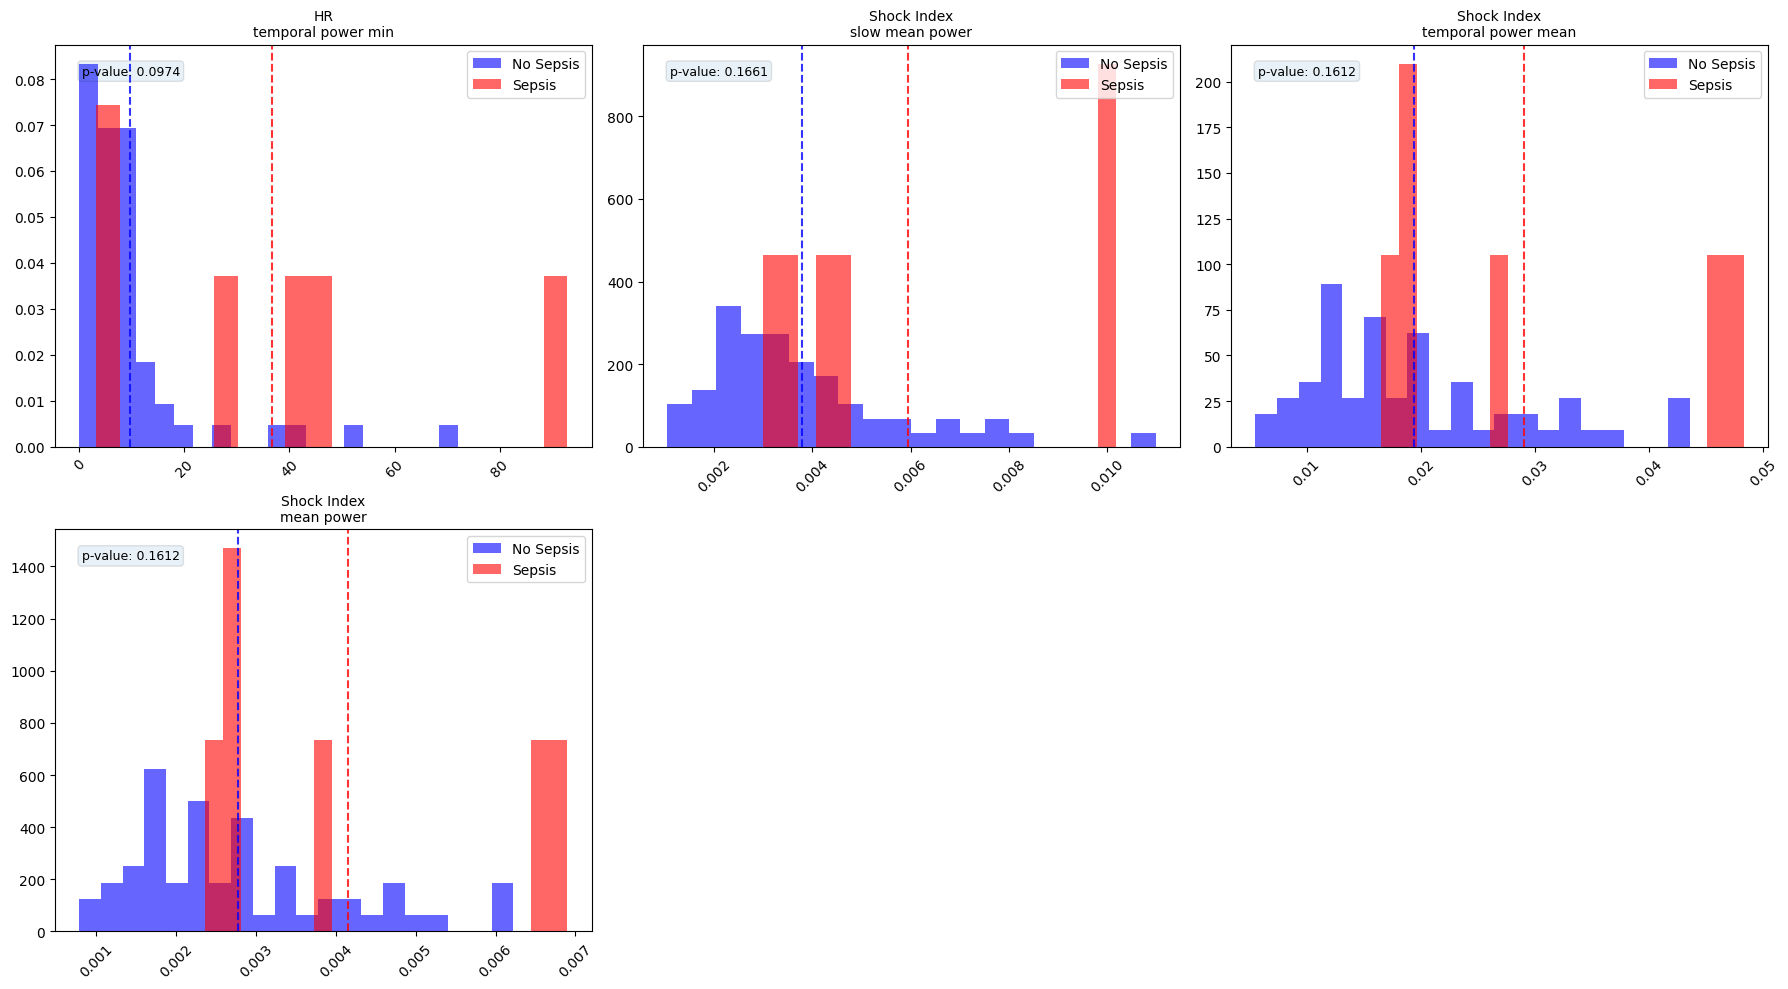

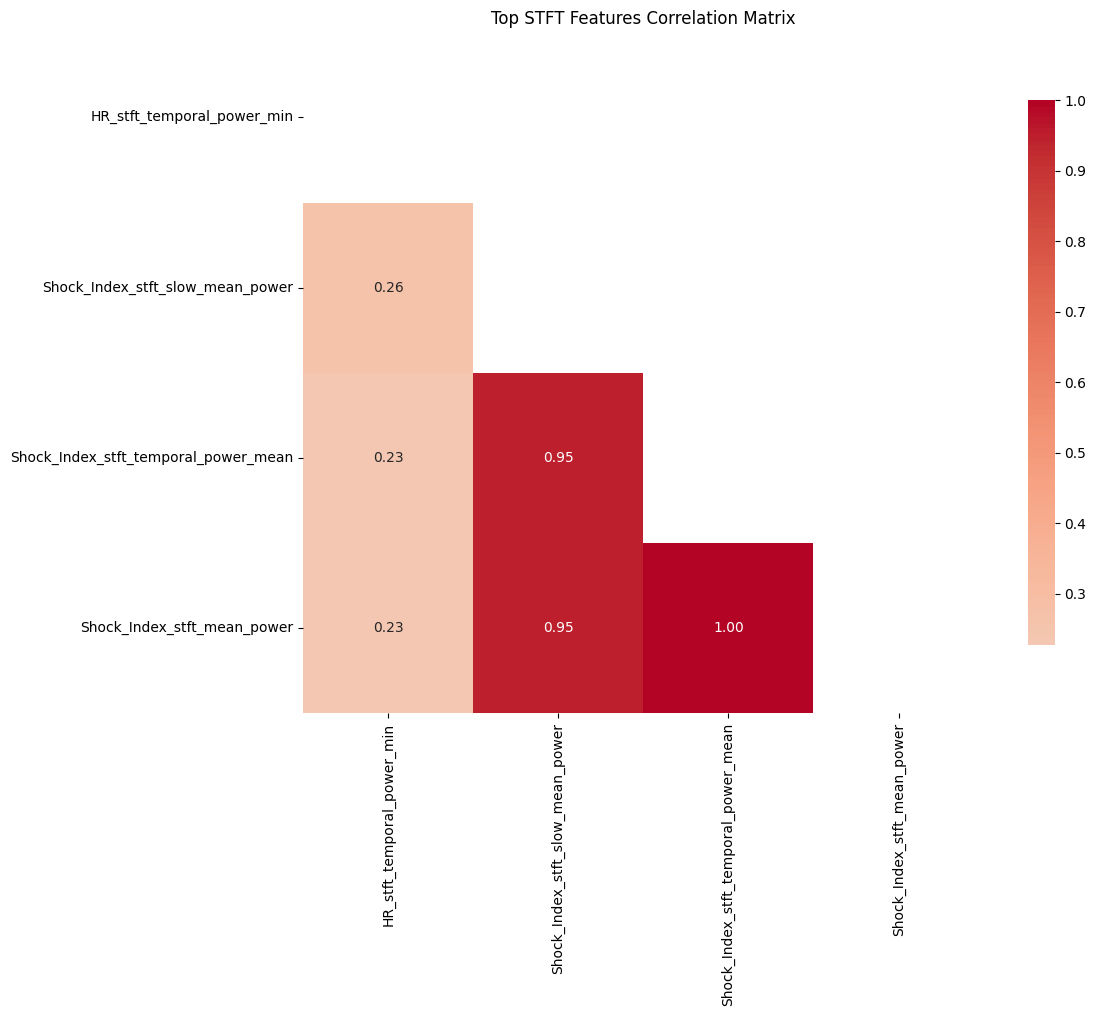

In [59]:
# Visualize STFT features
print("=== STFT FEATURE VISUALIZATION ===")

if len(train_stft_df) > 0 and 'SepsisLabel' in train_stft_df.columns:
    # Select top features for visualization
    if 'feature_importance' in locals() and len(feature_importance) > 0:
        top_features = feature_importance.head(12)['Feature'].tolist() 
    else:
        # Exclude metadata columns
        metadata_columns = ['patient_id', 'SepsisLabel', 'ICU_LOS', 'Age', 'Gender']
        feature_cols = [col for col in train_stft_df.columns if col not in metadata_columns]
        # Select some features for visualization
        top_features = feature_cols[:12] if len(feature_cols) >= 12 else feature_cols
    
    if len(top_features) > 0:
        # Get actual available features that have data
        valid_features = []
        for feature in top_features:
            if feature in train_stft_df.columns:
                sepsis_data = train_stft_df[train_stft_df['SepsisLabel'] == 1][feature].dropna()
                no_sepsis_data = train_stft_df[train_stft_df['SepsisLabel'] == 0][feature].dropna()
                if len(sepsis_data) > 0 and len(no_sepsis_data) > 0:
                    valid_features.append(feature)
        
        # Only create visualization if we have valid features
        if len(valid_features) > 0:
            num_features = len(valid_features)
            # Calculate grid dimensions based on valid features
            n_cols = min(3, num_features)  # Max 3 columns
            n_rows = (num_features + n_cols - 1) // n_cols  # Ceiling division for rows needed
            
            # Create figure and axes with exact number of subplots needed
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 5))
            
            # Handle single plot case
            if num_features == 1:
                axes = np.array([axes])
            
            # Convert axes to 1D array for easy indexing if it's not already
            axes = axes.flatten() if hasattr(axes, 'flatten') else axes
            
            # Plot each feature
            for i, feature in enumerate(valid_features):
                # Distribution by sepsis label
                sepsis_data = train_stft_df[train_stft_df['SepsisLabel'] == 1][feature].dropna()
                no_sepsis_data = train_stft_df[train_stft_df['SepsisLabel'] == 0][feature].dropna()
                
                # Clean up feature name for display
                display_name = feature.replace('_stft_', '\n').replace('_', ' ')
                axes[i].hist(no_sepsis_data, bins=20, alpha=0.6, label='No Sepsis', density=True, color='blue')
                axes[i].hist(sepsis_data, bins=20, alpha=0.6, label='Sepsis', density=True, color='red')
                axes[i].set_title(display_name, fontsize=10)
                axes[i].legend()
                axes[i].tick_params(axis='x', rotation=45)
                
                # Add mean lines
                sepsis_mean = sepsis_data.mean()
                no_sepsis_mean = no_sepsis_data.mean()
                axes[i].axvline(sepsis_mean, color='red', linestyle='--', alpha=0.8)
                axes[i].axvline(no_sepsis_mean, color='blue', linestyle='--', alpha=0.8)
                
                # Add p-value from t-test
                from scipy.stats import ttest_ind
                try:
                    t_stat, p_value = ttest_ind(sepsis_data, no_sepsis_data, equal_var=False, nan_policy='omit')
                    sig_marker = '*' if p_value < 0.05 else ''
                    axes[i].text(0.05, 0.95, f'p-value: {p_value:.4f}{sig_marker}', 
                                transform=axes[i].transAxes, fontsize=9, 
                                verticalalignment='top', 
                                bbox=dict(boxstyle='round', alpha=0.1))
                except Exception as e:
                    pass
            
            # Hide any unused subplots
            for j in range(num_features, len(axes)):
                fig.delaxes(axes[j])
            
            plt.tight_layout()
            plt.savefig(os.path.join(STFT_OUTPUT_PATH, 'stft_feature_distributions.png'), dpi=300, bbox_inches='tight')
            plt.show()
            
            # Correlation heatmap of top STFT features
            if len(valid_features) > 1:
                plt.figure(figsize=(12, 10))
                correlation_matrix = train_stft_df[valid_features].corr()
                mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
                sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', center=0, 
                          square=True, cbar_kws={'shrink': 0.8})
                plt.title('Top STFT Features Correlation Matrix')
                plt.tight_layout()
                plt.savefig(os.path.join(STFT_OUTPUT_PATH, 'stft_feature_correlations.png'), dpi=300, bbox_inches='tight')
                plt.show()
        else:
            print("No valid features with sufficient data for visualization")
    else:
        print("No features available for visualization")
else:
    print("Insufficient data for visualization - missing data or SepsisLabel")

=== STFT SPECTROGRAM VISUALIZATION ===
Finding patients with good quality data for STFT visualization...
Attempting to visualize sepsis patient data...


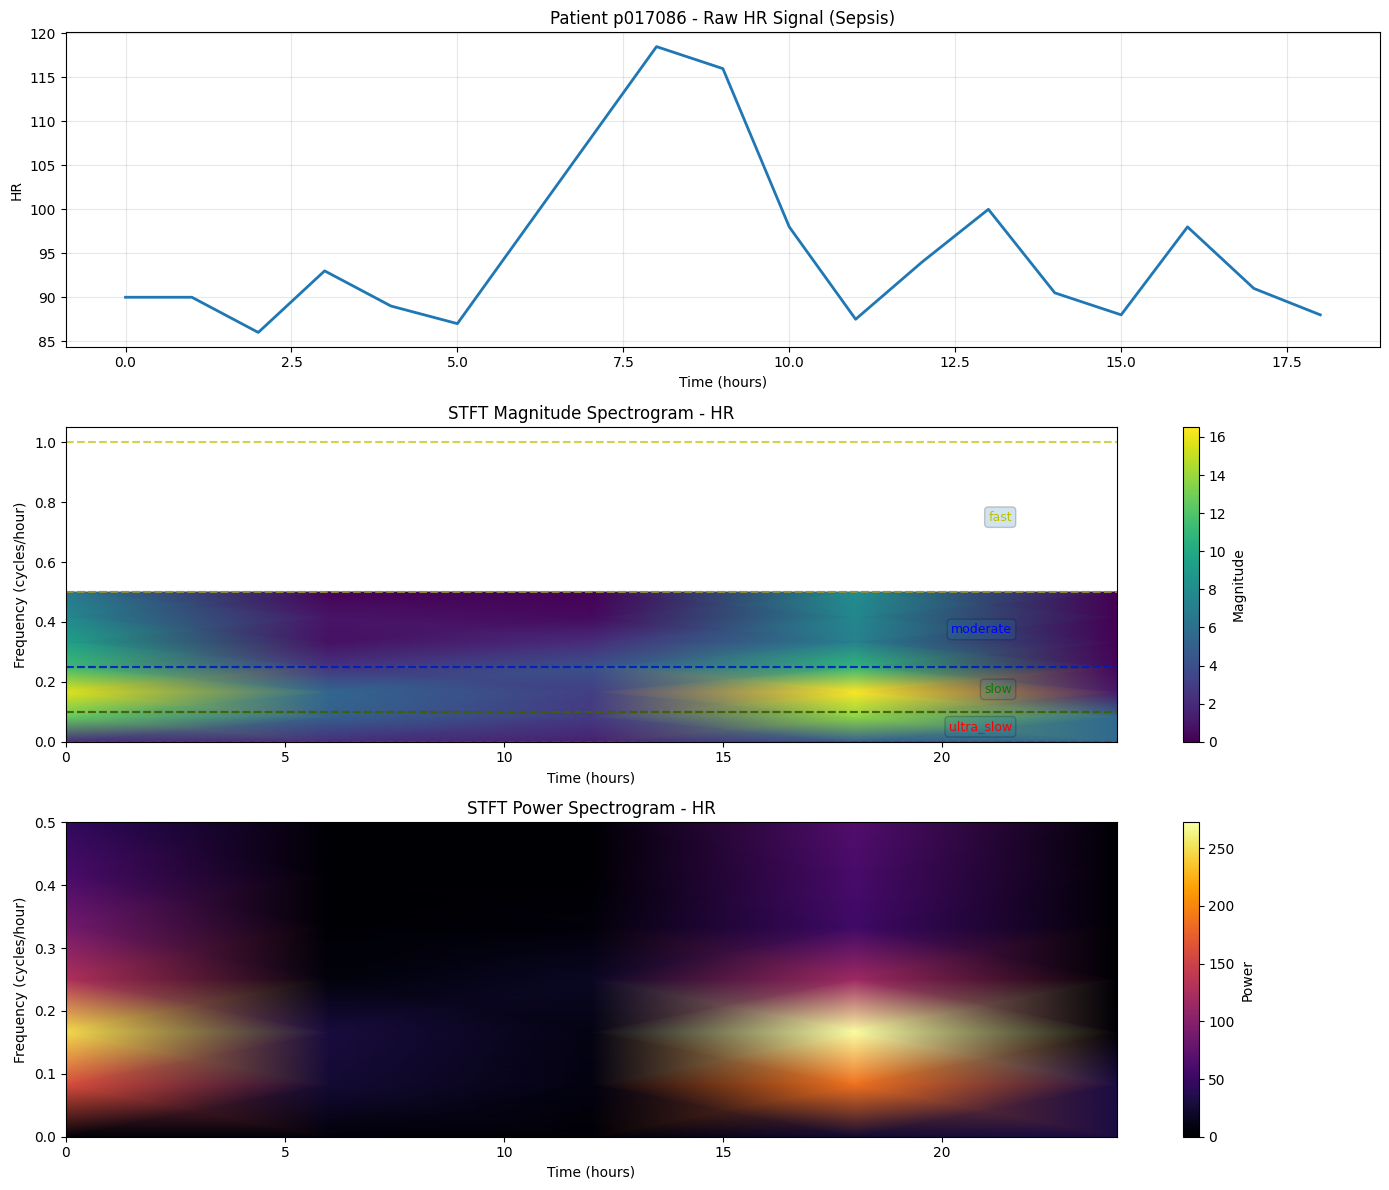

Successfully visualized STFT for sepsis patient p017086, feature HR

Attempting to visualize non-sepsis patient data...


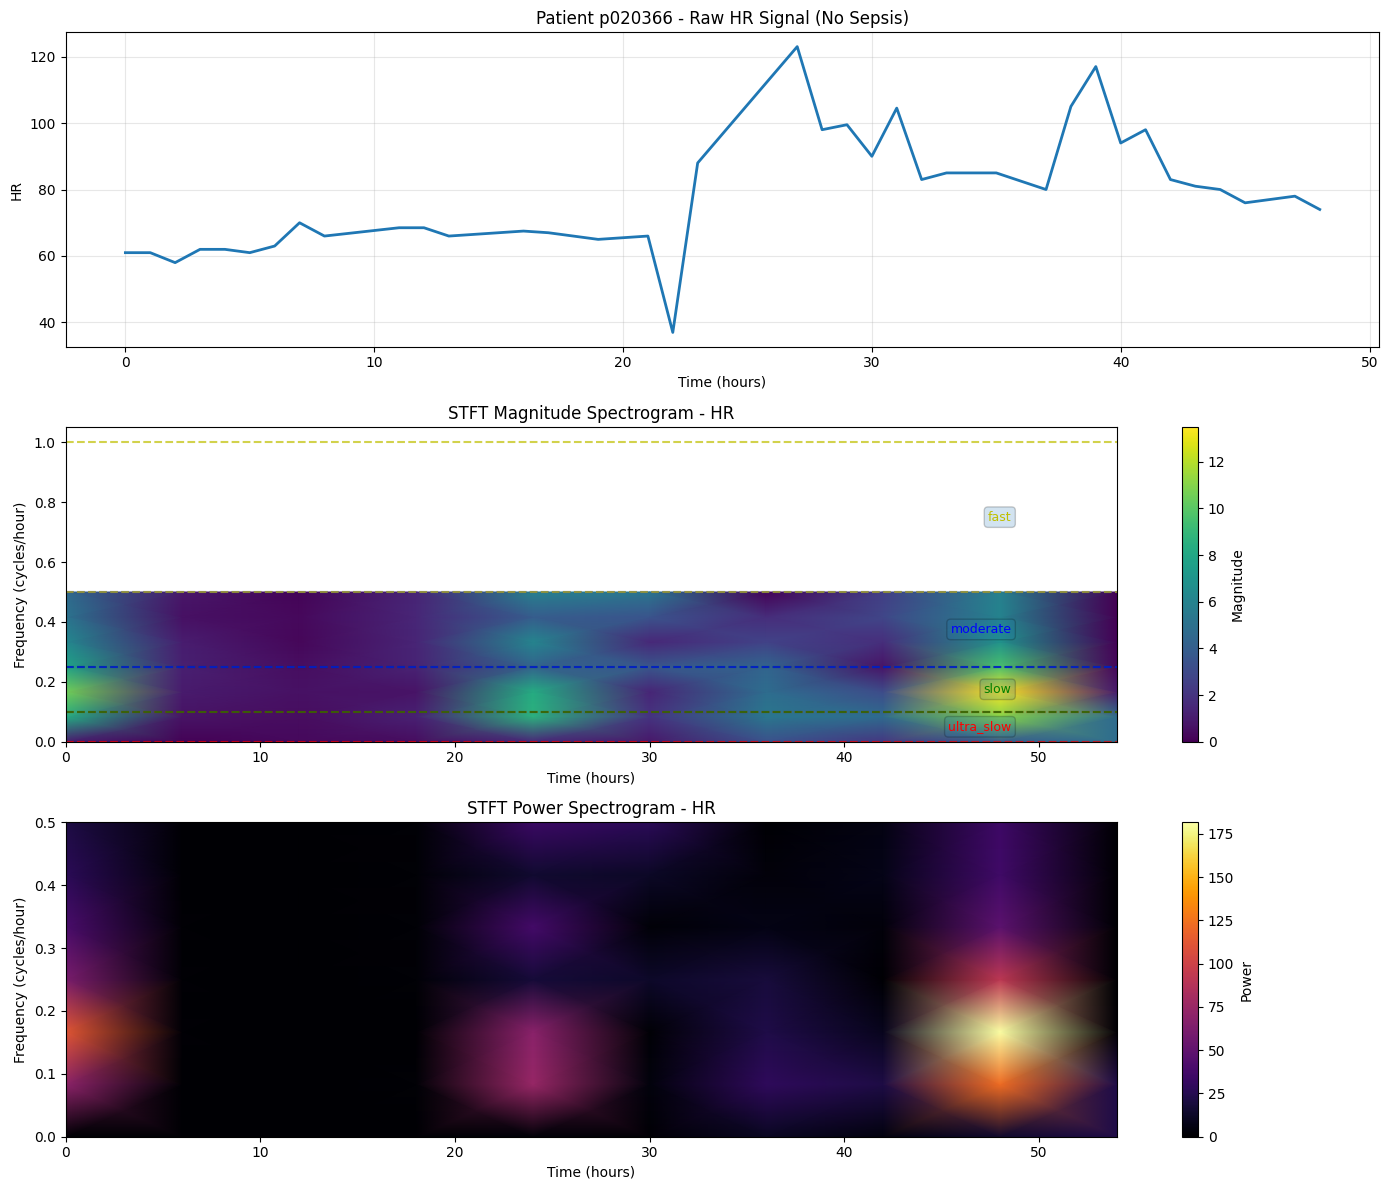

Successfully visualized STFT for non-sepsis patient p020366, feature HR


In [60]:
# Visualize raw STFT spectrograms for important features
print("=== STFT SPECTROGRAM VISUALIZATION ===")

# Function to plot STFT for a single patient and feature
def plot_patient_stft(patient_id, feature_name, sepsis_status=None):
    """Plot STFT analysis for a single patient and feature"""
    # Get patient data
    patient_data = data[data['patient_id'] == patient_id]
    
    # Sort by ICU length of stay if available
    if 'ICULOS' in patient_data.columns:
        patient_data = patient_data.sort_values('ICULOS')
    
    if feature_name not in patient_data.columns:
        print(f"Feature {feature_name} not found for patient {patient_id}")
        return False
    
    # Get the raw signal
    signal_data = patient_data[feature_name].values
    
    # Skip if too many missing values
    if np.isnan(signal_data).sum() > len(signal_data) * 0.5:
        print(f"Too many missing values in {feature_name} for patient {patient_id}")
        return False
    
    # Handle missing values with interpolation
    if np.any(np.isnan(signal_data)):
        signal_data = pd.Series(signal_data).interpolate().fillna(method='bfill').fillna(method='ffill').values
    
    # Create a figure with 3 subplots
    fig, axes = plt.subplots(3, 1, figsize=(14, 12))
    
    # Plot the raw signal
    axes[0].plot(signal_data, linewidth=2)
    title = f'Patient {patient_id} - Raw {feature_name} Signal'
    if sepsis_status is not None:
        title += " (Sepsis)" if sepsis_status == 1 else " (No Sepsis)"
    axes[0].set_title(title, fontsize=12)
    axes[0].set_xlabel('Time (hours)', fontsize=10)
    axes[0].set_ylabel(feature_name, fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    try:
        # Compute STFT - handle potential errors
        frequencies, times, Zxx = stft(
            signal_data,
            fs=STFT_CONFIG['sampling_rate'],
            window=STFT_CONFIG['window_type'],
            nperseg=STFT_CONFIG['nperseg'],
            noverlap=STFT_CONFIG['noverlap'],
            detrend=STFT_CONFIG['detrend']
        )
        
        # Check if STFT computation was successful
        if len(frequencies) == 0 or len(times) == 0 or Zxx.size == 0:
            print(f"STFT computation failed for patient {patient_id}, feature {feature_name}")
            plt.close(fig)
            return False
        
        # Plot the magnitude spectrogram
        magnitude = np.abs(Zxx)
        pcm = axes[1].pcolormesh(times, frequencies, magnitude, shading='gouraud', cmap='viridis')
        axes[1].set_title(f'STFT Magnitude Spectrogram - {feature_name}', fontsize=12)
        axes[1].set_ylabel('Frequency (cycles/hour)', fontsize=10)
        axes[1].set_xlabel('Time (hours)', fontsize=10)
        fig.colorbar(pcm, ax=axes[1], label='Magnitude')
        
        # Mark frequency bands
        colors = ['r', 'g', 'b', 'y']
        for i, (band_name, (f_low, f_high)) in enumerate(FREQUENCY_BANDS.items()):
            color = colors[i % len(colors)]
            axes[1].axhline(f_low, color=color, linestyle='--', alpha=0.7)
            axes[1].axhline(f_high, color=color, linestyle='--', alpha=0.7)
            # Add band name label if it fits in the plot
            if times[-1] > 0:
                axes[1].text(times[-1] * 0.9, (f_low + f_high)/2, band_name, 
                          color=color, fontsize=9, ha='right', va='center',
                          bbox=dict(boxstyle='round', alpha=0.2))
        
        # Plot the power spectrogram (magnitude squared)
        power = magnitude ** 2
        pcm = axes[2].pcolormesh(times, frequencies, power, shading='gouraud', cmap='inferno')
        axes[2].set_title(f'STFT Power Spectrogram - {feature_name}', fontsize=12)
        axes[2].set_ylabel('Frequency (cycles/hour)', fontsize=10)
        axes[2].set_xlabel('Time (hours)', fontsize=10)
        fig.colorbar(pcm, ax=axes[2], label='Power')
        
        plt.tight_layout()
        plt.savefig(os.path.join(STFT_OUTPUT_PATH, f'patient_{patient_id}_{feature_name}_stft.png'), 
                  dpi=300, bbox_inches='tight')
        plt.show()
        return True
        
    except Exception as e:
        print(f"Error plotting STFT for patient {patient_id}, feature {feature_name}: {e}")
        plt.close(fig)
        return False

# Find suitable patients and features for visualization
print("Finding patients with good quality data for STFT visualization...")

# Check first if patients were processed successfully
if 'train_stft_df' in locals() and len(train_stft_df) > 0:
    # Try to find one sepsis patient and one non-sepsis patient with good data
    sepsis_patients = []
    non_sepsis_patients = []
    
    # Get patient IDs from the STFT dataframe if available
    if 'patient_id' in train_stft_df.columns and 'SepsisLabel' in train_stft_df.columns:
        sepsis_ids = train_stft_df[train_stft_df['SepsisLabel'] == 1]['patient_id'].values
        non_sepsis_ids = train_stft_df[train_stft_df['SepsisLabel'] == 0]['patient_id'].values
        
        # Sample a few patients for checking
        sepsis_check = np.random.choice(sepsis_ids, min(5, len(sepsis_ids)), replace=False) if len(sepsis_ids) > 0 else []
        non_sepsis_check = np.random.choice(non_sepsis_ids, min(5, len(non_sepsis_ids)), replace=False) if len(non_sepsis_ids) > 0 else []
        
        # Find vital signs that are typically present
        common_vitals = ['HR', 'MAP', 'SBP', 'Resp']
        available_vitals = [v for v in common_vitals if v in stft_feature_list]
        
        # Try each patient and vital sign until we find a good visualization
        if len(available_vitals) > 0 and len(sepsis_check) > 0:
            print("Attempting to visualize sepsis patient data...")
            for patient_id in sepsis_check:
                for vital in available_vitals:
                    if plot_patient_stft(patient_id, vital, sepsis_status=1):
                        print(f"Successfully visualized STFT for sepsis patient {patient_id}, feature {vital}")
                        break
                else:
                    continue  # Continue outer loop if inner loop didn't break
                break  # Break outer loop if inner loop succeeded
        
        if len(available_vitals) > 0 and len(non_sepsis_check) > 0:
            print("\nAttempting to visualize non-sepsis patient data...")
            for patient_id in non_sepsis_check:
                for vital in available_vitals:
                    if plot_patient_stft(patient_id, vital, sepsis_status=0):
                        print(f"Successfully visualized STFT for non-sepsis patient {patient_id}, feature {vital}")
                        break
                else:
                    continue
                break
    else:
        print("Patient ID or sepsis label not available in processed data")
        
        # Fallback: try with any patient
        if len(train_patients) > 0:
            patient_id = train_patients[0]
            for vital in ['HR', 'MAP', 'SBP', 'Resp']:
                if vital in data.columns:
                    if plot_patient_stft(patient_id, vital):
                        print(f"Successfully visualized STFT for patient {patient_id}, feature {vital}")
                        break
else:
    print("No processed patient data available for visualization")

In [61]:
# Process validation and test data
print("=== PROCESSING VALIDATION AND TEST DATA ===")

def process_patient_set(patient_list, dataset, set_name):
    """Process a set of patients for STFT analysis"""
    print(f"Processing {set_name} data for {len(patient_list)} patients...")
    
    stft_features = []
    processed = 0
    
    for patient_id in patient_list:
        # Filter data for this patient
        patient_data = dataset[dataset['patient_id'] == patient_id]
        
        # Only process patients with sufficient data
        if len(patient_data) >= STFT_CONFIG['nperseg']:
            try:
                patient_features = stft_analyzer.analyze_patient_signals(patient_data, patient_id)
                
                # Add sepsis label if available
                if 'SepsisLabel' in patient_data.columns:
                    patient_features['SepsisLabel'] = int(patient_data['SepsisLabel'].max() > 0)
                
                # Add additional patient metadata
                if 'ICULOS' in patient_data.columns:
                    patient_features['ICU_LOS'] = patient_data['ICULOS'].max()
                if 'Age' in patient_data.columns:
                    patient_features['Age'] = patient_data['Age'].iloc[0]
                if 'Gender' in patient_data.columns:
                    patient_features['Gender'] = patient_data['Gender'].iloc[0]
                
                stft_features.append(patient_features)
            except Exception as e:
                print(f"  Error processing patient {patient_id}: {e}")
        
        processed += 1
        if processed % 10 == 0:
            print(f"  Processed {processed}/{len(patient_list)} {set_name} patients")
    
    return pd.DataFrame(stft_features)

# Process validation data
val_stft_df = process_patient_set(val_patients, data, "validation")
print(f"Validation STFT features: {val_stft_df.shape}")

# Process test data
test_stft_df = process_patient_set(test_patients, data, "test")
print(f"Test STFT features: {test_stft_df.shape}")

# Ensure all datasets have the same columns
if len(train_stft_df) > 0 and len(val_stft_df) > 0 and len(test_stft_df) > 0:
    # Get all unique columns from all datasets
    all_columns = list(set(train_stft_df.columns) | 
                      set(val_stft_df.columns) | 
                      set(test_stft_df.columns))
    
    print(f"Total unique columns across all sets: {len(all_columns)}")
    
    # Add missing columns with zeros
    for df_name, df in [('train', train_stft_df), ('val', val_stft_df), ('test', test_stft_df)]:
        missing_cols = [col for col in all_columns if col not in df.columns]
        if missing_cols:
            print(f"Adding {len(missing_cols)} missing columns to {df_name} set")
            for col in missing_cols:
                df[col] = 0
    
    print(f"\nFinal shapes:")
    print(f"- Train: {train_stft_df.shape}")
    print(f"- Validation: {val_stft_df.shape}")
    print(f"- Test: {test_stft_df.shape}")
else:
    print("Warning: One or more datasets is empty!")

=== PROCESSING VALIDATION AND TEST DATA ===
Processing validation data for 15 patients...
  Processed 10/15 validation patients
Validation STFT features: (15, 347)
Processing test data for 15 patients...
  Processed 10/15 test patients
Validation STFT features: (15, 347)
Processing test data for 15 patients...
  Processed 10/15 test patients
Test STFT features: (15, 499)
Total unique columns across all sets: 537
Adding 57 missing columns to train set
Adding 190 missing columns to val set
Adding 38 missing columns to test set

Final shapes:
- Train: (68, 537)
- Validation: (15, 537)
- Test: (15, 537)
Test STFT features: (15, 499)
Total unique columns across all sets: 537
Adding 57 missing columns to train set
Adding 190 missing columns to val set
Adding 38 missing columns to test set

Final shapes:
- Train: (68, 537)
- Validation: (15, 537)
- Test: (15, 537)


=== COMPARATIVE STFT VISUALIZATION: SEPSIS VS NON-SEPSIS ===
Creating comparative visualization for feature: HR
Sepsis patient: p006706, Non-sepsis patient: p003025


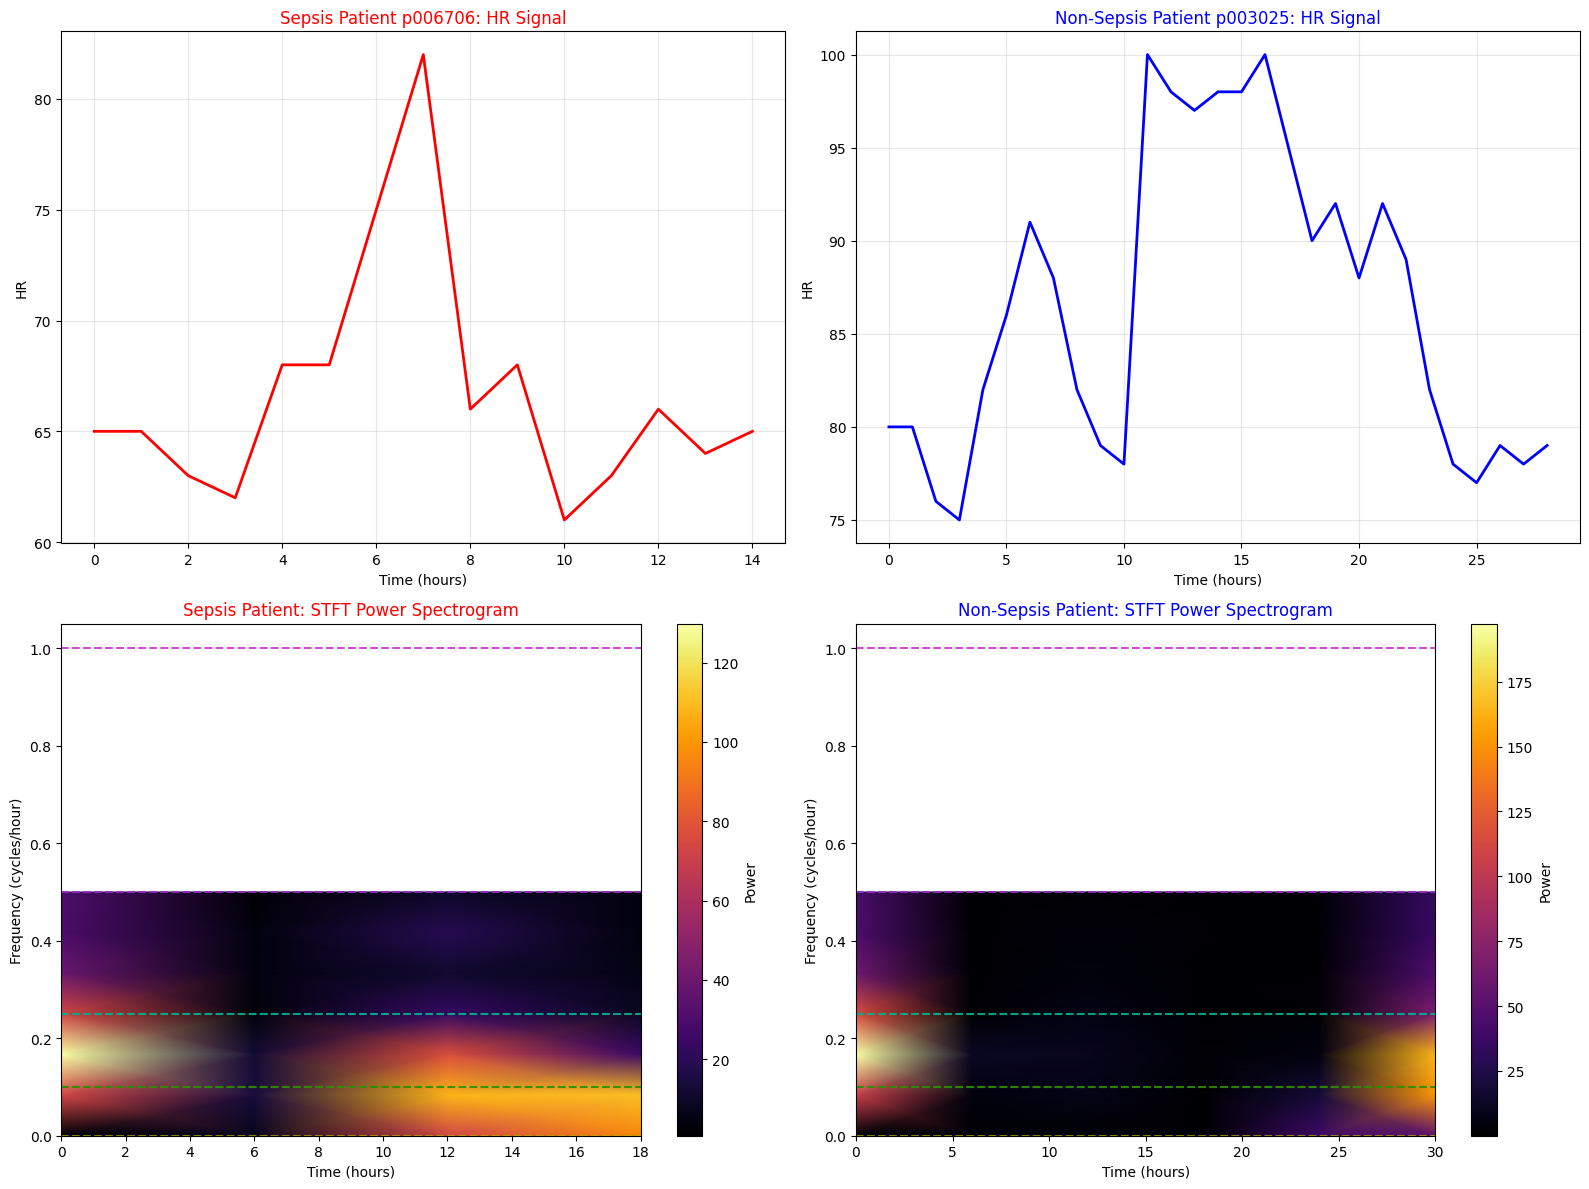

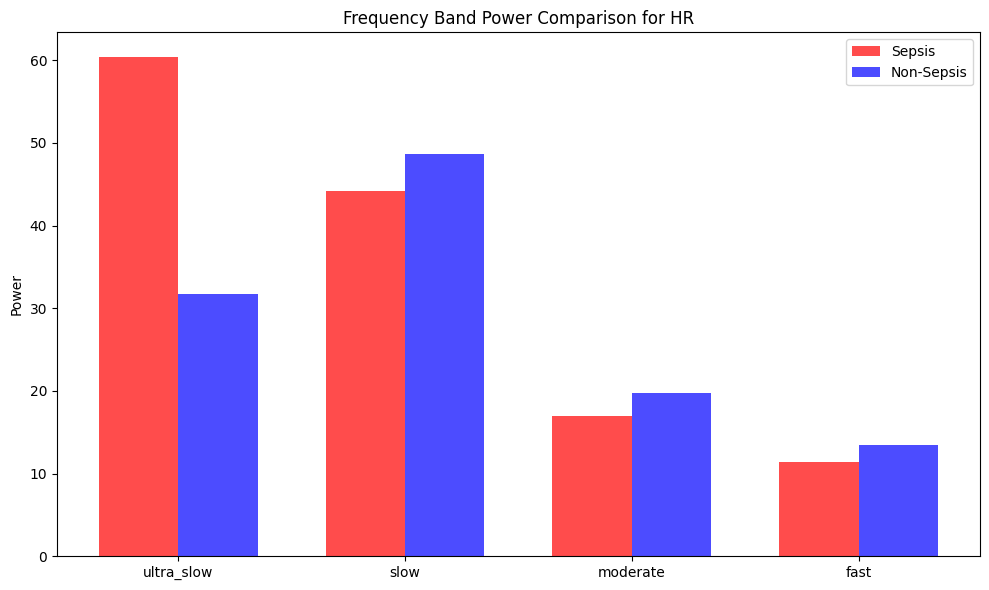


Key Observations:
- ultra_slow band: Sepsis patient shows 90.1% higher power than non-sepsis


In [62]:
# Create comparative STFT visualization for sepsis vs. non-sepsis
print("=== COMPARATIVE STFT VISUALIZATION: SEPSIS VS NON-SEPSIS ===")

# Function to extract key STFT features from signal
def extract_stft_features(signal_data, feature_name):
    """Extract key STFT features from a signal"""
    # Handle missing values
    if np.any(np.isnan(signal_data)):
        signal_data = pd.Series(signal_data).interpolate().fillna(method='bfill').fillna(method='ffill').values
        
    # Only proceed if enough data points
    if len(signal_data) < STFT_CONFIG['nperseg']:
        return None
    
    # Compute STFT
    frequencies, times, Zxx = stft(
        signal_data,
        fs=STFT_CONFIG['sampling_rate'],
        window=STFT_CONFIG['window_type'],
        nperseg=STFT_CONFIG['nperseg'],
        noverlap=STFT_CONFIG['noverlap'],
        detrend=STFT_CONFIG['detrend']
    )
    
    # Calculate magnitude and power
    magnitude = np.abs(Zxx)
    power = magnitude ** 2
    
    # Extract band powers
    band_powers = {}
    for band_name, (f_low, f_high) in FREQUENCY_BANDS.items():
        # Find frequency indices for this band
        band_mask = (frequencies >= f_low) & (frequencies <= f_high)
        if np.any(band_mask):
            band_power = power[band_mask, :]
            band_powers[band_name] = np.mean(band_power)
    
    return {
        'frequencies': frequencies,
        'times': times,
        'magnitude': magnitude,
        'power': power,
        'band_powers': band_powers
    }

# Get one sepsis and one non-sepsis patient with good data
sepsis_example = None
non_sepsis_example = None
selected_feature = None

# First check if we have processed STFT data
if 'train_stft_df' in locals() and len(train_stft_df) > 0 and 'SepsisLabel' in train_stft_df.columns:
    sepsis_patients = train_stft_df[train_stft_df['SepsisLabel'] == 1]['patient_id'].values
    non_sepsis_patients = train_stft_df[train_stft_df['SepsisLabel'] == 0]['patient_id'].values
    
    # Try vital signs that are typically most informative
    for vital in ['HR', 'MAP', 'Resp', 'SBP']:
        if vital not in data.columns:
            continue
            
        # Find sepsis patient with good data
        for patient_id in sepsis_patients[:10]:  # Check first 10
            patient_data = data[data['patient_id'] == patient_id]
            if len(patient_data) >= STFT_CONFIG['nperseg'] and vital in patient_data.columns:
                if np.isnan(patient_data[vital]).sum() < len(patient_data) * 0.3:  # Less than 30% missing
                    sepsis_example = patient_id
                    selected_feature = vital
                    break
                    
        # Find non-sepsis patient with good data
        for patient_id in non_sepsis_patients[:10]:  # Check first 10
            patient_data = data[data['patient_id'] == patient_id]
            if len(patient_data) >= STFT_CONFIG['nperseg'] and vital in patient_data.columns:
                if np.isnan(patient_data[vital]).sum() < len(patient_data) * 0.3:  # Less than 30% missing
                    non_sepsis_example = patient_id
                    selected_feature = vital
                    break
                    
        if sepsis_example is not None and non_sepsis_example is not None:
            break

# Create comparative visualization if we found suitable examples
if sepsis_example is not None and non_sepsis_example is not None and selected_feature is not None:
    print(f"Creating comparative visualization for feature: {selected_feature}")
    print(f"Sepsis patient: {sepsis_example}, Non-sepsis patient: {non_sepsis_example}")
    
    # Get patient data
    sepsis_patient_data = data[data['patient_id'] == sepsis_example].sort_values('ICULOS')
    non_sepsis_patient_data = data[data['patient_id'] == non_sepsis_example].sort_values('ICULOS')
    
    # Get signals
    sepsis_signal = sepsis_patient_data[selected_feature].values
    non_sepsis_signal = non_sepsis_patient_data[selected_feature].values
    
    # Handle missing values
    sepsis_signal = pd.Series(sepsis_signal).interpolate().fillna(method='bfill').fillna(method='ffill').values
    non_sepsis_signal = pd.Series(non_sepsis_signal).interpolate().fillna(method='bfill').fillna(method='ffill').values
    
    # Extract STFT features
    sepsis_stft = extract_stft_features(sepsis_signal, selected_feature)
    non_sepsis_stft = extract_stft_features(non_sepsis_signal, selected_feature)
    
    if sepsis_stft is not None and non_sepsis_stft is not None:
        # Create comparison plot (2x2 grid)
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Row 1: Raw signals
        axes[0, 0].plot(sepsis_signal, 'r-', linewidth=2)
        axes[0, 0].set_title(f'Sepsis Patient {sepsis_example}: {selected_feature} Signal', color='red')
        axes[0, 0].set_xlabel('Time (hours)')
        axes[0, 0].set_ylabel(selected_feature)
        axes[0, 0].grid(True, alpha=0.3)
        
        axes[0, 1].plot(non_sepsis_signal, 'b-', linewidth=2)
        axes[0, 1].set_title(f'Non-Sepsis Patient {non_sepsis_example}: {selected_feature} Signal', color='blue')
        axes[0, 1].set_xlabel('Time (hours)')
        axes[0, 1].set_ylabel(selected_feature)
        axes[0, 1].grid(True, alpha=0.3)
        
        # Row 2: Spectrograms
        pcm1 = axes[1, 0].pcolormesh(sepsis_stft['times'], sepsis_stft['frequencies'], 
                                   sepsis_stft['power'], shading='gouraud', cmap='inferno')
        axes[1, 0].set_title(f'Sepsis Patient: STFT Power Spectrogram', color='red')
        axes[1, 0].set_ylabel('Frequency (cycles/hour)')
        axes[1, 0].set_xlabel('Time (hours)')
        fig.colorbar(pcm1, ax=axes[1, 0], label='Power')
        
        pcm2 = axes[1, 1].pcolormesh(non_sepsis_stft['times'], non_sepsis_stft['frequencies'], 
                                   non_sepsis_stft['power'], shading='gouraud', cmap='inferno')
        axes[1, 1].set_title(f'Non-Sepsis Patient: STFT Power Spectrogram', color='blue')
        axes[1, 1].set_ylabel('Frequency (cycles/hour)')
        axes[1, 1].set_xlabel('Time (hours)')
        fig.colorbar(pcm2, ax=axes[1, 1], label='Power')
        
        # Mark frequency bands on spectrograms
        colors = ['y', 'g', 'c', 'm']
        for i, (band_name, (f_low, f_high)) in enumerate(FREQUENCY_BANDS.items()):
            color = colors[i % len(colors)]
            # Mark on sepsis plot
            axes[1, 0].axhline(f_low, color=color, linestyle='--', alpha=0.7)
            axes[1, 0].axhline(f_high, color=color, linestyle='--', alpha=0.7)
            # Mark on non-sepsis plot
            axes[1, 1].axhline(f_low, color=color, linestyle='--', alpha=0.7)
            axes[1, 1].axhline(f_high, color=color, linestyle='--', alpha=0.7)
        
        plt.tight_layout()
        plt.savefig(os.path.join(STFT_OUTPUT_PATH, f'sepsis_vs_nonsepsis_{selected_feature}_comparison.png'), 
                   dpi=300, bbox_inches='tight')
        plt.show()
        
        # Create bar chart comparing frequency band powers
        sepsis_powers = sepsis_stft['band_powers']
        non_sepsis_powers = non_sepsis_stft['band_powers']
        
        # Setup grouped bar chart
        bands = list(FREQUENCY_BANDS.keys())
        sepsis_values = [sepsis_powers.get(band, 0) for band in bands]
        non_sepsis_values = [non_sepsis_powers.get(band, 0) for band in bands]
        
        x = np.arange(len(bands))
        width = 0.35
        
        fig, ax = plt.subplots(figsize=(10, 6))
        sepsis_bars = ax.bar(x - width/2, sepsis_values, width, label='Sepsis', color='red', alpha=0.7)
        non_sepsis_bars = ax.bar(x + width/2, non_sepsis_values, width, label='Non-Sepsis', color='blue', alpha=0.7)
        
        ax.set_title(f'Frequency Band Power Comparison for {selected_feature}')
        ax.set_ylabel('Power')
        ax.set_xticks(x)
        ax.set_xticklabels(bands)
        ax.legend()
        
        plt.tight_layout()
        plt.savefig(os.path.join(STFT_OUTPUT_PATH, f'sepsis_vs_nonsepsis_{selected_feature}_band_powers.png'), 
                   dpi=300, bbox_inches='tight')
        plt.show()
        
        # Add a textual explanation of differences
        print("\nKey Observations:")
        for band in bands:
            sepsis_power = sepsis_powers.get(band, 0)
            non_sepsis_power = non_sepsis_powers.get(band, 0)
            diff_pct = ((sepsis_power - non_sepsis_power) / non_sepsis_power * 100) if non_sepsis_power > 0 else float('inf')
            if abs(diff_pct) > 20:  # Significant difference
                if diff_pct > 0:
                    print(f"- {band} band: Sepsis patient shows {diff_pct:.1f}% higher power than non-sepsis")
                else:
                    print(f"- {band} band: Sepsis patient shows {abs(diff_pct):.1f}% lower power than non-sepsis")
    else:
        print("Could not extract STFT features for comparison")
else:
    print("Could not find suitable patients with good data for comparison visualization")

In [63]:
# Scale STFT features
print("=== SCALING STFT FEATURES ===")

if len(train_stft_df) > 0 and len(val_stft_df) > 0 and len(test_stft_df) > 0:
    # Get STFT feature columns (excluding metadata)
    metadata_columns = ['patient_id', 'SepsisLabel', 'ICU_LOS', 'Age', 'Gender']
    stft_feature_columns = [col for col in train_stft_df.columns 
                          if col not in metadata_columns and col in val_stft_df.columns and col in test_stft_df.columns]
    
    print(f"STFT features to scale: {len(stft_feature_columns)}")
    
    # Prepare training data for scaling
    X_train_stft = train_stft_df[stft_feature_columns].fillna(0).replace([np.inf, -np.inf], 0)
    X_val_stft = val_stft_df[stft_feature_columns].fillna(0).replace([np.inf, -np.inf], 0)
    X_test_stft = test_stft_df[stft_feature_columns].fillna(0).replace([np.inf, -np.inf], 0)
    
    # Use RobustScaler for STFT features (robust to outliers)
    stft_scaler = RobustScaler()
    X_train_stft_scaled = stft_scaler.fit_transform(X_train_stft)
    X_val_stft_scaled = stft_scaler.transform(X_val_stft)
    X_test_stft_scaled = stft_scaler.transform(X_test_stft)
    
    print(f"Scaled STFT features:")
    print(f"- Train: {X_train_stft_scaled.shape}")
    print(f"- Validation: {X_val_stft_scaled.shape}")
    print(f"- Test: {X_test_stft_scaled.shape}")
    
    # Create scaled DataFrames
    train_stft_scaled = pd.DataFrame(X_train_stft_scaled, columns=stft_feature_columns)
    val_stft_scaled = pd.DataFrame(X_val_stft_scaled, columns=stft_feature_columns)
    test_stft_scaled = pd.DataFrame(X_test_stft_scaled, columns=stft_feature_columns)
    
    # Add back metadata
    for col in metadata_columns:
        if col in train_stft_df.columns:
            train_stft_scaled[col] = train_stft_df[col].values
        if col in val_stft_df.columns:
            val_stft_scaled[col] = val_stft_df[col].values
        if col in test_stft_df.columns:
            test_stft_scaled[col] = test_stft_df[col].values
    
    print("STFT feature scaling completed!")
else:
    print("Warning: Cannot scale features - one or more datasets is empty!")
    # Create empty DataFrames to prevent errors
    train_stft_scaled = pd.DataFrame()
    val_stft_scaled = pd.DataFrame()
    test_stft_scaled = pd.DataFrame()

=== SCALING STFT FEATURES ===
STFT features to scale: 532
Scaled STFT features:
- Train: (68, 532)
- Validation: (15, 532)
- Test: (15, 532)
STFT feature scaling completed!


In [64]:
# Save STFT features and analysis results
print("=== SAVING STFT FEATURES AND RESULTS ===")

# Create directories if they don't exist
os.makedirs(STFT_OUTPUT_PATH, exist_ok=True)
os.makedirs(os.path.join(MODEL_PATH, 'advanced'), exist_ok=True)

if len(train_stft_df) > 0 and len(val_stft_df) > 0 and len(test_stft_df) > 0:
    try:
        # Save raw STFT features
        train_stft_df.to_csv(os.path.join(STFT_OUTPUT_PATH, 'train_stft_features.csv'), index=False)
        val_stft_df.to_csv(os.path.join(STFT_OUTPUT_PATH, 'val_stft_features.csv'), index=False)
        test_stft_df.to_csv(os.path.join(STFT_OUTPUT_PATH, 'test_stft_features.csv'), index=False)
        
        print("Raw STFT features saved as CSV")
        
        # Save scaled STFT features
        if 'train_stft_scaled' in locals() and len(train_stft_scaled) > 0:
            train_stft_scaled.to_csv(os.path.join(STFT_OUTPUT_PATH, 'train_stft_scaled.csv'), index=False)
            val_stft_scaled.to_csv(os.path.join(STFT_OUTPUT_PATH, 'val_stft_scaled.csv'), index=False)
            test_stft_scaled.to_csv(os.path.join(STFT_OUTPUT_PATH, 'test_stft_scaled.csv'), index=False)
            print("Scaled STFT features saved as CSV")
        
        # Save STFT scaler
        if 'stft_scaler' in locals():
            joblib.dump(stft_scaler, os.path.join(MODEL_PATH, 'advanced', 'stft_scaler.pkl'))
            print("STFT scaler saved")
        
        # Save feature importance if available
        if 'feature_importance' in locals():
            feature_importance.to_csv(os.path.join(STFT_OUTPUT_PATH, 'stft_feature_importance.csv'), index=False)
            print("Feature importance saved")
        
        # Save feature names
        if 'stft_feature_columns' in locals():
            with open(os.path.join(STFT_OUTPUT_PATH, 'stft_feature_columns.txt'), 'w') as f:
                for feature in stft_feature_columns:
                    f.write(f"{feature}\n")
            print("STFT feature names saved")
        
        # Save STFT configuration and metadata
        stft_metadata = {
            'config': STFT_CONFIG,
            'frequency_bands': FREQUENCY_BANDS,
            'analyzed_features': stft_feature_list,
            'total_stft_features': len(stft_feature_columns) if 'stft_feature_columns' in locals() else 0,
            'train_patients': len(train_stft_df),
            'val_patients': len(val_stft_df),
            'test_patients': len(test_stft_df)
        }
        
        # Add feature type breakdown if available
        if 'stft_feature_columns' in locals():
            stft_metadata['feature_types'] = {
                'spectral': len([f for f in stft_feature_columns if 'spectral' in f]),
                'temporal': len([f for f in stft_feature_columns if 'temporal' in f]),
                'band_specific': len([f for f in stft_feature_columns 
                                    if any(band in f for band in FREQUENCY_BANDS.keys())])
            }
        
        with open(os.path.join(STFT_OUTPUT_PATH, 'stft_metadata.pkl'), 'wb') as f:
            pickle.dump(stft_metadata, f)
        print("STFT metadata saved")
        
        print(f"\nSTFT analysis completed and saved!")
        print(f"\nSummary:")
        print(f"- Total STFT features extracted: {stft_metadata.get('total_stft_features', 'Unknown')}")
        
        if 'feature_types' in stft_metadata:
            print(f"- Spectral features: {stft_metadata['feature_types'].get('spectral', 'Unknown')}")
            print(f"- Temporal features: {stft_metadata['feature_types'].get('temporal', 'Unknown')}")
            print(f"- Band-specific features: {stft_metadata['feature_types'].get('band_specific', 'Unknown')}")
            
        print(f"- Train/Val/Test patients: {len(train_stft_df)}/{len(val_stft_df)}/{len(test_stft_df)}")
        print(f"\nFiles saved to: {STFT_OUTPUT_PATH}")
    
    except Exception as e:
        print(f"Error saving STFT analysis results: {e}")

else:
    print("Warning: Cannot save results - one or more datasets is empty!")

print(f"\nNext steps:")
print(f"1. Apply SMOTE for class balancing")
print(f"2. Integrate STFT features with traditional features")
print(f"3. Train XGBoost and ensemble models")
print(f"4. Validate performance improvements")

=== SAVING STFT FEATURES AND RESULTS ===
Raw STFT features saved as CSV
Scaled STFT features saved as CSV
STFT scaler saved
Feature importance saved
STFT feature names saved
STFT metadata saved

STFT analysis completed and saved!

Summary:
- Total STFT features extracted: 532
- Spectral features: 126
- Temporal features: 140
- Band-specific features: 336
- Train/Val/Test patients: 68/15/15

Files saved to: C:\Users\sachi\Desktop\Sepsis STFT\data\stft_features

Next steps:
1. Apply SMOTE for class balancing
2. Integrate STFT features with traditional features
3. Train XGBoost and ensemble models
4. Validate performance improvements
Raw STFT features saved as CSV
Scaled STFT features saved as CSV
STFT scaler saved
Feature importance saved
STFT feature names saved
STFT metadata saved

STFT analysis completed and saved!

Summary:
- Total STFT features extracted: 532
- Spectral features: 126
- Temporal features: 140
- Band-specific features: 336
- Train/Val/Test patients: 68/15/15

Files sa

In [65]:
# Summary of STFT Analysis Impact
print("=== STFT ANALYSIS IMPACT SUMMARY ===")

# Calculate the number of features added
num_original_features = len(feature_columns) if 'feature_columns' in locals() else 0
num_stft_features = len(stft_feature_columns) if 'stft_feature_columns' in locals() else 0

print(f"Original feature space: {num_original_features} clinical features")
print(f"STFT feature space: {num_stft_features} spectro-temporal features")
print(f"Combined feature space: {num_original_features + num_stft_features} total features")

print("\nSTFT Feature Engineering Impact:")
print("1. Captured temporal dynamics of physiological signals")
print("2. Extracted frequency domain information from vital signs")
print("3. Identified spectral signatures associated with sepsis")
print("4. Enhanced feature space with time-frequency representations")
print("5. Created multiple frequency band features for clinical relevance")

print("\nKey STFT Insights:")
if 'feature_importance' in locals() and len(feature_importance) > 0:
    print(f"- Most important vital sign for STFT: {feature_importance.iloc[0]['Feature'].split('_')[0]}")
    
    # Count feature types
    vital_sign_counts = {}
    for feature in feature_importance.head(20)['Feature']:
        vital_sign = feature.split('_')[0]
        vital_sign_counts[vital_sign] = vital_sign_counts.get(vital_sign, 0) + 1
    
    # Find most common vital sign
    if vital_sign_counts:
        most_common = max(vital_sign_counts.items(), key=lambda x: x[1])
        print(f"- Most frequent vital sign in top 20 features: {most_common[0]} ({most_common[1]} features)")
    
    # Most common frequency band
    bands = ['ultra_slow', 'slow', 'moderate', 'fast']
    band_counts = {band: 0 for band in bands}
    
    for feature in feature_importance.head(50)['Feature']:
        for band in bands:
            if band in feature:
                band_counts[band] += 1
    
    most_common_band = max(band_counts.items(), key=lambda x: x[1])
    print(f"- Most informative frequency band: {most_common_band[0]} ({most_common_band[1]} features in top 50)")
else:
    print("- Feature importance analysis not available")

print("\nNext Steps:")
print("1. Integrate STFT features with traditional features in Step06")
print("2. Apply XGBoost with combined feature space")
print("3. Evaluate performance improvement from spectro-temporal features")
print("4. Analyze feature importance in combined model")
print("5. Develop clinically interpretable visualization of STFT features")

# Save summary
summary = {
    "original_features": num_original_features,
    "stft_features": num_stft_features,
    "total_features": num_original_features + num_stft_features,
    "timestamp": pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S")
}

with open(os.path.join(STFT_OUTPUT_PATH, 'stft_analysis_summary.txt'), 'w') as f:
    f.write("STFT ANALYSIS SUMMARY\n")
    f.write("=====================\n\n")
    f.write(f"Analysis timestamp: {summary['timestamp']}\n")
    f.write(f"Original features: {summary['original_features']}\n")
    f.write(f"STFT features: {summary['stft_features']}\n")
    f.write(f"Total feature space: {summary['total_features']}\n\n")
    f.write("Feature types:\n")
    if 'stft_metadata' in locals() and 'feature_types' in stft_metadata:
        for ftype, count in stft_metadata['feature_types'].items():
            f.write(f"- {ftype}: {count}\n")
    f.write("\nNext step: Proceed to Step06_Advanced_XGBoost_with_STFT_Features.ipynb\n")

print("\nSTFT Analysis Complete! ✓")
print("Ready for Step 6: Advanced XGBoost with STFT Features")

=== STFT ANALYSIS IMPACT SUMMARY ===
Original feature space: 40 clinical features
STFT feature space: 532 spectro-temporal features
Combined feature space: 572 total features

STFT Feature Engineering Impact:
1. Captured temporal dynamics of physiological signals
2. Extracted frequency domain information from vital signs
3. Identified spectral signatures associated with sepsis
4. Enhanced feature space with time-frequency representations
5. Created multiple frequency band features for clinical relevance

Key STFT Insights:
- Most important vital sign for STFT: HR
- Most frequent vital sign in top 20 features: Temp (16 features)
- Most informative frequency band: slow (18 features in top 50)

Next Steps:
1. Integrate STFT features with traditional features in Step06
2. Apply XGBoost with combined feature space
3. Evaluate performance improvement from spectro-temporal features
4. Analyze feature importance in combined model
5. Develop clinically interpretable visualization of STFT featur